# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [150]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [151]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 1001 # максимальное число эпох плюс один изза range - я уменьшил циклы обучения иначе обучается часами....
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 20 # каждые 10 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

train_count = 30 # количество выборок для обучения

In [152]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# преобразование к виду ванхот векторов
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(buffer_size=1024).batch(batch_size).prefetch(1)

In [153]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activate = 'relu', name=None):
        super().__init__(name=name)
        # Место для вашего кода
        # инициализация начальных весов - нормальное распределение с матожиданием 0 и распределением 0.1
        self.w = tf.random.truncated_normal([in_features, out_features], stddev=0.1, name='w')
        # инициализация вектора весов смещения - нули
        self.b = tf.zeros([out_features], dtype=tf.float32, name="b")

        # преобразовуем в переменные
        self.w = tf.Variable(self.w)
        self.b = tf.Variable(self.b)

        # сохраняем атрибут типа фугкции активации внутри экземпляра класса
        self.activate = activate



    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        # вычисляем выход согласно заданной функции активации
        if self.activate == 'relu':
          return tf.nn.relu(y)
        elif self.activate == 'softmax':
          return tf.nn.softmax(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer1 = DenseLayer(num_features, n_hidden_1, activate='relu') # 28*28 - входных фич, распротраняем на 128 нейронов

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, activate='relu') # 128 - входных фич, распротраняем на 256 нейронов

    # Выходной слой
    # Место для вашего кода
    self.layer3 = DenseLayer(n_hidden_2, num_classes, activate='softmax') # 256 - входных фич, распротраняем на 1 выходной нейрон



  def __call__(self, x):
    # Место для вашего кода
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов
    # функцию активации встроили прямо в инициализацию класса, поэтому функтор достаточо простой

    # я понимаю что занимаю лишнюю память, если не переопределяю результат, а выделяю каждой последующей строке
    # свою переменную, но может я захочу посмотреть промежуточные результаты по слоям
    y1 = self.layer1(x)
    y2 = self.layer2(y1)
    y_out = self.layer3(y2)
    return y_out

In [154]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, y_pred)
    return acc.result().numpy() * 100

In [155]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Для подгонки весов сети будем использовать стохастический градиентный спуск
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)

# Функция обучения нейросети
def train(nn, input_x, output_y):

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    grads = g.gradient(loss, [nn.layer1.trainable_variables, nn.layer2.trainable_variables, nn.layer3.trainable_variables])

    # Вычислим по ним значение градиента
    # Место для вашего кода

    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(grads[0], nn.layer1.trainable_variables))
    optimizer.apply_gradients(zip(grads[1], nn.layer2.trainable_variables))
    optimizer.apply_gradients(zip(grads[2], nn.layer3.trainable_variables))

  return loss

In [156]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети
step_history = []
# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
ds_train = train_data.take(train_count)
for step in range(training_steps):
  for batch_x, batch_y in ds_train:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    # чтобы не вычислять повторно потерю - она возвращатеся после цикла тренировки
    loss_i = train(neural_net, batch_x, batch_y)

  if step % display_step == 0:
    loss_history.append(loss_i)
    pred = neural_net(x_test)
    pred2 = tf.argmax(pred, axis=1).numpy()
    acc_i = accuracy(pred2, y_test)
    accuracy_history.append(acc_i)
    step_history.append(step)
    print(f"Step: {step}, loss: {loss_i:.4f}, accuracy: {acc_i:.4f}")


Step: 0, loss: 2.3638, accuracy: 9.4800
Step: 20, loss: 1.6949, accuracy: 58.0000
Step: 40, loss: 1.2873, accuracy: 72.2600
Step: 60, loss: 1.0471, accuracy: 78.4100
Step: 80, loss: 0.8407, accuracy: 81.5000
Step: 100, loss: 0.8025, accuracy: 83.3900
Step: 120, loss: 0.5142, accuracy: 84.4200
Step: 140, loss: 0.5660, accuracy: 85.2000
Step: 160, loss: 0.4809, accuracy: 85.7400
Step: 180, loss: 0.5347, accuracy: 86.4300
Step: 200, loss: 0.5234, accuracy: 86.9000
Step: 220, loss: 0.4172, accuracy: 87.2400
Step: 240, loss: 0.4693, accuracy: 87.6600
Step: 260, loss: 0.4500, accuracy: 88.0100
Step: 280, loss: 0.4723, accuracy: 88.2500
Step: 300, loss: 0.4091, accuracy: 88.4600
Step: 320, loss: 0.4004, accuracy: 88.7500
Step: 340, loss: 0.4934, accuracy: 89.0200
Step: 360, loss: 0.3638, accuracy: 89.2200
Step: 380, loss: 0.3428, accuracy: 89.3900
Step: 400, loss: 0.4026, accuracy: 89.5200
Step: 420, loss: 0.3783, accuracy: 89.6300
Step: 440, loss: 0.3589, accuracy: 89.8300
Step: 460, loss: 0

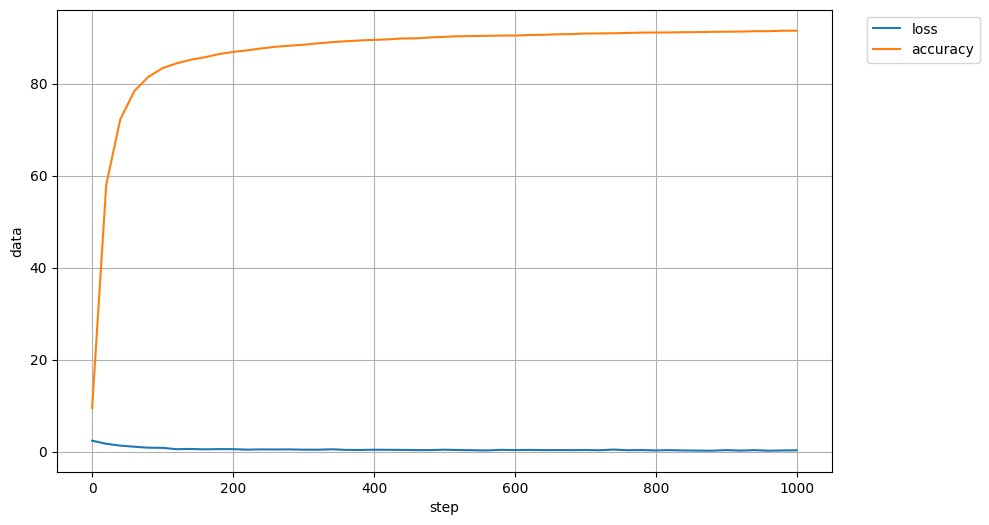

In [157]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
plt.figure(figsize = (10, 6))
plt.plot(step_history, loss_history, label='loss')
plt.plot(step_history, accuracy_history, label='accuracy')
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.xlabel('step')
plt.ylabel('data')
plt.grid()
plt.show()

In [158]:
# Вычислите точность обученной нейросети

# Место для вашего кода
pred = neural_net(x_test)
pred2 = tf.argmax(pred, axis=1).numpy()
acc = len(y_test[y_test == pred2])/y_test.shape[0] * 100  # любопытная строка - надо разобраться
print(acc)

91.51


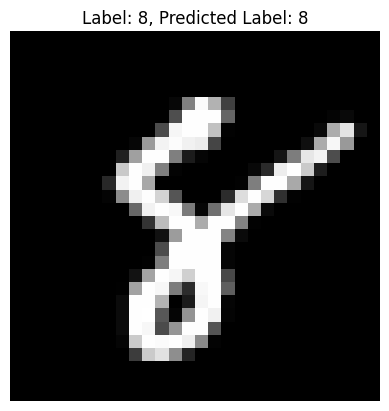

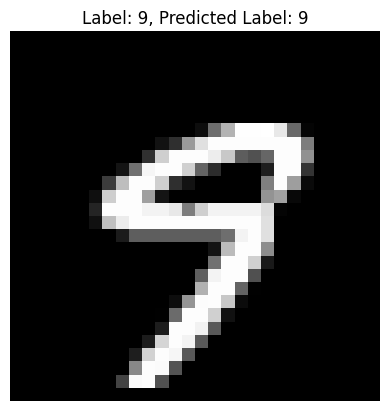

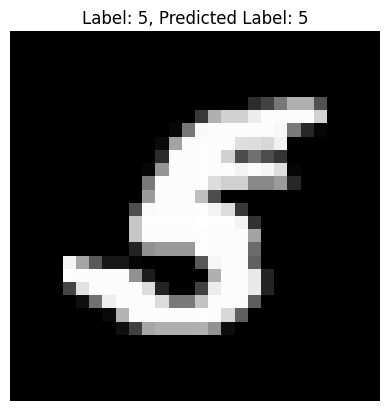

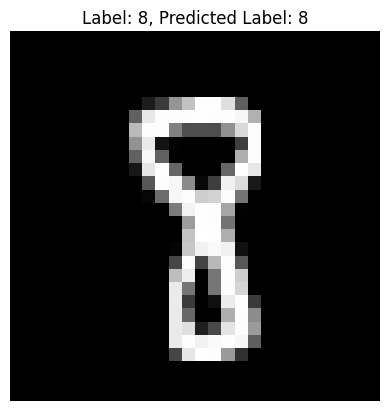

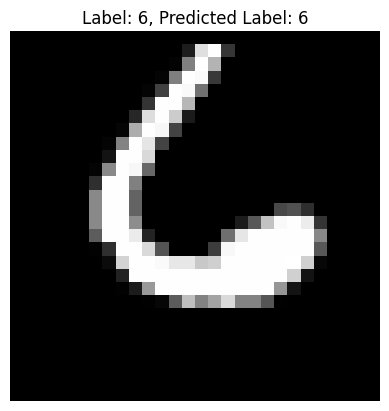

Accuracy test -  100.0%


In [159]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
# Написано с помощью VitalyZatoka
import random
count_test = 5

random_indices = random.sample(range(len(x_test)), count_test)
im_test = x_test[random_indices]
dig_test = y_test[random_indices]

preds = neural_net(im_test)
# преобразовуем из ванхот в привічній десятичній вид
pred_digits = tf.argmax(preds, axis=1)


count_acc = 0

for i in range(len(im_test)):
    image = im_test[i].reshape((28, 28))
    label = dig_test[i]
    pred = pred_digits[i]
    if pred == label:
      x = 100/count_test
      count_acc += x
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {label}, Predicted Label: {pred}")
    plt.show()

print(f'Accuracy test -  {count_acc}%')